# Reinforcement learning

In [9]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import time

### Environment  Setup

In [ ]:
class GridWorld:
    def __init__(self, size=10, goal_state=100, walls=None):
        # inicializar a grid
        self.size = size
        self.goal_state = goal_state
        self.walls = walls if walls is not None else []
        self.actions = ['up', 'down', 'left', 'right']
        self.reset()
    
    def reset(self):
        """Reset to initial state"""
        self.current_state = 1
        return self.current_state
    
    def state_to_coords(self, state):
        """Convert state number to (row, col) coordinates"""
        # o estado 1 é (0,0), o estado 10 é (0,9) e o estado 11 é (1,0)
        row = (state - 1) // self.size
        col = (state - 1) % self.size
        return row, col
    
    def coords_to_state(self, row, col):
        """Convert (row, col) coordinates to state number"""
        # confirmar se está dentro do perímetro
        if row < 0 or row >= self.size or col < 0 or col >= self.size:
            return None
        return row * self.size + col + 1
    
    def transition(self, state, action):
        """State transition function: f(s, a) = s'"""
        row, col = self.state_to_coords(state)
        
        if action == 'up':
            row -= 1
        elif action == 'down':
            row += 1
        elif action == 'left':
            col -= 1
        elif action == 'right':
            col += 1
        
        next_state = self.coords_to_state(row, col)
        
        # confirmar o perímetro, se estiver fora, continuar no estado atual e levar uma penalização caso existam paredes
        if next_state is None:
            return state, -0.1 if len(self.walls) > 0 else 0
        
        # confirmar se existem paredes
        if next_state in self.walls:
            return state, -0.1
        
        return next_state, 0
    
    def reward(self, state):
        """Reward function"""
        # recebe +100 caso chegue ao objetivo, 0 nas outras posições
        if state == self.goal_state:
            return 100
        return 0
    
    def step(self, action):
        """Execute action and return next state, reward, done"""
        next_state, wall_penalty = self.transition(self.current_state, action)
        reward = self.reward(next_state) + wall_penalty
        done = (next_state == self.goal_state)
        self.current_state = next_state
        return next_state, reward, done

In [ ]:
# iniciar o ambient sem paredes, numa fase inicial
env = GridWorld(size=10, goal_state=100)
print("Environment initialized")
print(f"Initial state: {env.current_state}")
print(f"Goal state: {env.goal_state}")

Environment initialized
Initial state: 1
Goal state: 100


### Q-Learning

In [ ]:
class QLearningAgent:
    def __init__(self, n_states, n_actions, alpha=0.7, gamma=0.99):
        # inicializar a Q-table com zeros e indexar os estados
        self.n_states = n_states
        self.n_actions = n_actions
        self.alpha = alpha #learning rate
        self.gamma = gamma #discount factor
        self.Q = np.zeros((n_states + 1, n_actions))  # +1 for 1-indexed states
        self.action_names = ['up', 'down', 'left', 'right']
    
    def get_best_action(self, state):
        """Get best action for state (random tie-breaking)"""
        q_values = self.Q[state]
        max_q = np.max(q_values)
        best_actions = np.where(q_values == max_q)[0]
        return np.random.choice(best_actions)
    
    def get_action(self, state, greed=1.0):
        """
        Get action using epsilon-greedy strategy.
        greed=1.0 means always best action, greed=0.0 means random
        """
        if np.random.random() < greed:
            return self.get_best_action(state)
        else:
            return np.random.randint(self.n_actions)
    
    def update(self, state, action, reward, next_state):
        """Update Q-table using Q-learning rule"""
        best_next_q = np.max(self.Q[next_state])
        target = reward + self.gamma * best_next_q
        self.Q[state, action] = (1 - self.alpha) * self.Q[state, action] + self.alpha * target
    
    def get_q_max(self):
        """Get maximum Q-value for each state"""
        return np.max(self.Q, axis=1)


## 3.

### 3.1

In [ ]:
def train_qlearning(env, agent, n_steps, greed=1.0, test_points=None):
    """
    Train Q-learning agent.
    If test_points provided, run tests at those steps.
    """
    if test_points is None:
        test_points = []
    
    test_results = []
    step = 0
    episode_steps = 0
    
    state = env.reset()
    
    while step < n_steps:
        # selecionar e executar a ação
        action = agent.get_action(state, greed=greed)
        next_state, reward, done = env.step(agent.action_names[action])
        
        # atualizar a Q-table
        agent.update(state, action, reward, next_state)
        
        state = next_state
        step += 1
        episode_steps += 1
        
        # verificar o ponto de teste
        if step in test_points:
            test_reward = run_test(env, agent, max_steps=1000)
            test_results.append((step, test_reward))
        
        # reset caso tenha atingido o número máximo de passos
        if done or episode_steps >= 1000:
            state = env.reset()
            episode_steps = 0
    
    return test_results

def run_test(env, agent, max_steps=1000):
    """Run test episode using only best actions"""
    state = env.reset()
    total_reward = 0
    
    for _ in range(max_steps):
        action = agent.get_best_action(state)
        next_state, reward, done = env.step(agent.action_names[action])
        total_reward += reward
        state = next_state
        
        if done:
            break
    
    # normalizar a recompensa por passos máximos para a comparação
    return total_reward / max_steps


In [ ]:
# testar com diferentes valores de greed
print("Exercise 3.1 - Testing different greed parameters\n")

greed_values = [0.2, 0.5, 0.9]
n_tests = 30
n_steps = 20000
test_points = [100, 500, 1000, 2500, 5000, 7500, 10000, 15000, 20000]

results_by_greed = {}

for greed in greed_values:
    print(f"Testing greed={greed}...")
    results_by_greed[greed] = []
    
    for seed in range(n_tests):
        np.random.seed(seed) #seed fixa
        env = GridWorld(size=10, goal_state=100)
        agent = QLearningAgent(n_states=100, n_actions=4, alpha=0.7, gamma=0.99)
        
        test_results = train_qlearning(env, agent, n_steps, greed=greed, test_points=test_points)
        results_by_greed[greed].append(test_results)
    
    print(f"  Completed {n_tests} runs\n")


Exercise 3.1 - Testing different greed parameters

Testing greed=0.2...
  Completed 30 runs

Testing greed=0.5...
  Completed 30 runs

Testing greed=0.9...
  Completed 30 runs



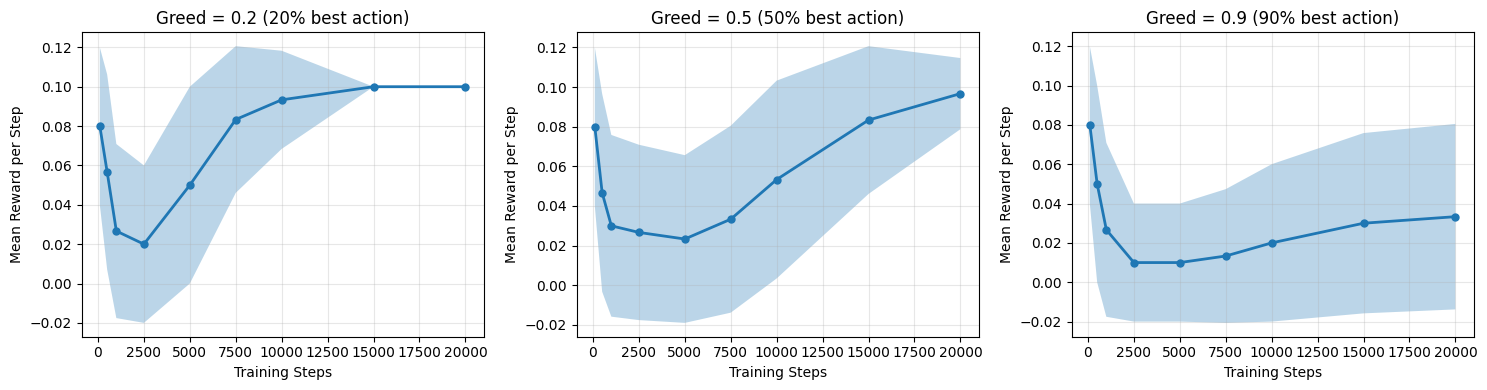


Final performance (at 20000 steps):
Greed 0.2: 0.1000 ± 0.0000
Greed 0.5: 0.0967 ± 0.0180
Greed 0.9: 0.0333 ± 0.0471


In [ ]:
# plot dos resultados para uma greed fixa, ou seja, o gráfico apresenta a recompensa média por etapa ao longo das etapas de treino

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, greed in enumerate(greed_values):
    ax = axes[idx]
    
    # organizar os dados por ponto de teste
    rewards_by_step = {step: [] for step in test_points}
    
    for test_run in results_by_greed[greed]:
        for step, reward in test_run:
            rewards_by_step[step].append(reward)
    
    # calcular o valor de média e desvio padrão
    steps = list(rewards_by_step.keys())
    means = [np.mean(rewards_by_step[s]) for s in steps]
    stds = [np.std(rewards_by_step[s]) for s in steps]
    
    ax.plot(steps, means, 'o-', linewidth=2, markersize=5)
    ax.fill_between(steps, 
                     np.array(means) - np.array(stds),
                     np.array(means) + np.array(stds),
                     alpha=0.3)
    ax.set_xlabel('Training Steps')
    ax.set_ylabel('Mean Reward per Step')
    ax.set_title(f'Greed = {greed} ({int(greed*100)}% best action)')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nFinal performance (at 20000 steps):")
for greed in greed_values:
    final_rewards = [test_run[-1][1] for test_run in results_by_greed[greed]]
    print(f"Greed {greed}: {np.mean(final_rewards):.4f} ± {np.std(final_rewards):.4f}")


## 3.2

In [ ]:
# aumentar o valor de greed
#começa com um valor baixo de greed e aumenta gradualmente até 1
def train_qlearning_increasing_greed(env, agent, n_steps, initial_greed=0.3, test_points=None):
    """
    Train with increasing greed: starts at initial_greed, increases to 1.0
    """
    if test_points is None:
        test_points = []
    
    test_results = []
    step = 0
    episode_steps = 0
    
    state = env.reset()
    
    greed_start_step = 0
    greed_end_step = int(n_steps * 0.3)  # First 30% at initial greed
    
    while step < n_steps:
        # calcular a greed atual
        if step < greed_end_step:
            greed = initial_greed
        else:
            # aumento linear do valor de greed, do valor de initial_greed até 1.0
            progress = (step - greed_end_step) / (n_steps - greed_end_step)
            greed = initial_greed + (1.0 - initial_greed) * progress
        
        # selecionar e executar a ação
        action = agent.get_action(state, greed=greed)
        next_state, reward, done = env.step(agent.action_names[action])
        
        # atualizar Q-table
        agent.update(state, action, reward, next_state)
        
        state = next_state
        step += 1
        episode_steps += 1
        
        # verificar o test point
        if step in test_points:
            test_reward = run_test(env, agent, max_steps=1000)
            test_results.append((step, test_reward))
        
        # reset se tiver alcançado o objetivo final ou o número máximo de passos
        if done or episode_steps >= 1000:
            state = env.reset()
            episode_steps = 0
    
    return test_results

print("Exercise 3.2 - Testing increasing greed parameter\n")

results_increasing = []

for seed in range(n_tests):
    np.random.seed(seed)
    env = GridWorld(size=10, goal_state=100)
    agent = QLearningAgent(n_states=100, n_actions=4, alpha=0.7, gamma=0.99)
    
    test_results = train_qlearning_increasing_greed(env, agent, n_steps, 
                                                     initial_greed=0.3, 
                                                     test_points=test_points)
    results_increasing.append(test_results)

print(f"Completed {n_tests} runs with increasing greed\n")


Exercise 3.2 - Testing increasing greed parameter

Completed 30 runs with increasing greed



C:\Users\Ana Maria Ribeiro\AppData\Local\Temp\ipykernel_1660\248277684.py:43: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(final_rewards, labels=strategies)


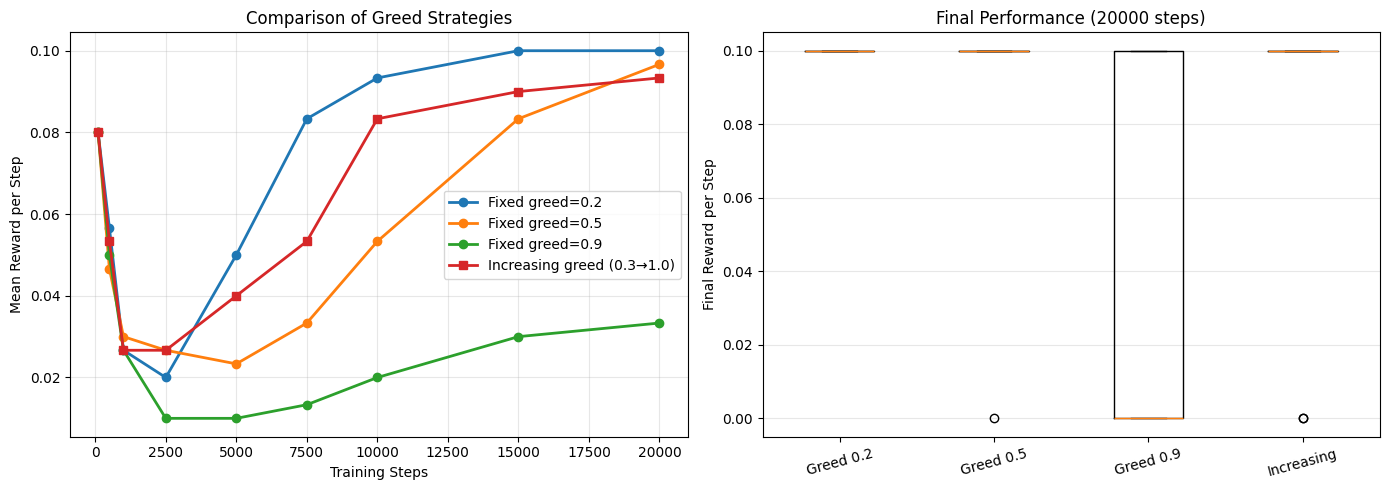


Final performance comparison (at 20000 steps):
Strategy             Mean       Std       
----------------------------------------
Greed 0.2            0.1000    0.0000
Greed 0.5            0.0967    0.0180
Greed 0.9            0.0333    0.0471
Increasing           0.0933    0.0249

Conclusions:
- Low greed (0.2): High exploration, slow convergence
- High greed (0.9): Fast initial learning, may miss optimal policy
- Increasing greed: Balances exploration and exploitation
- Best strategy typically: increasing greed or moderate fixed greed (0.5)


In [ ]:
# comparar todas as estratégias para a greed0

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# plot 1: todas as estratégias ao longo do tempo
for greed in greed_values:
    rewards_by_step = {step: [] for step in test_points}
    for test_run in results_by_greed[greed]:
        for step, reward in test_run:
            rewards_by_step[step].append(reward)
    
    steps = list(rewards_by_step.keys())
    means = [np.mean(rewards_by_step[s]) for s in steps]
    ax1.plot(steps, means, 'o-', label=f'Fixed greed={greed}', linewidth=2)

# adicionar a greed que aumenta ao longo do tempo
rewards_by_step = {step: [] for step in test_points}
for test_run in results_increasing:
    for step, reward in test_run:
        rewards_by_step[step].append(reward)

steps = list(rewards_by_step.keys())
means = [np.mean(rewards_by_step[s]) for s in steps]
ax1.plot(steps, means, 's-', label='Increasing greed (0.3→1.0)', linewidth=2, markersize=6)

ax1.set_xlabel('Training Steps')
ax1.set_ylabel('Mean Reward per Step')
ax1.set_title('Comparison of Greed Strategies')
ax1.legend()
ax1.grid(alpha=0.3)

# plot 2: comparação final da performance
strategies = ['Greed 0.2', 'Greed 0.5', 'Greed 0.9', 'Increasing']
final_rewards = []

for greed in greed_values:
    rewards = [test_run[-1][1] for test_run in results_by_greed[greed]]
    final_rewards.append(rewards)

rewards = [test_run[-1][1] for test_run in results_increasing]
final_rewards.append(rewards)

ax2.boxplot(final_rewards, labels=strategies)
ax2.set_ylabel('Final Reward per Step')
ax2.set_title('Final Performance (20000 steps)')
ax2.grid(alpha=0.3, axis='y')
ax2.tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()

print("\nFinal performance comparison (at 20000 steps):")
print(f"{'Strategy':<20} {'Mean':<10} {'Std':<10}")
print("-" * 40)
for i, strategy in enumerate(strategies):
    mean_reward = np.mean(final_rewards[i])
    std_reward = np.std(final_rewards[i])
    print(f"{strategy:<20} {mean_reward:.4f}    {std_reward:.4f}")

print("\nConclusions:")
print("- Low greed (0.2): High exploration, slow convergence")
print("- High greed (0.9): Fast initial learning, may miss optimal policy")
print("- Increasing greed: Balances exploration and exploitation")
print("- Best strategy typically: increasing greed or moderate fixed greed (0.5)")



Visualizing learned Q-tables...



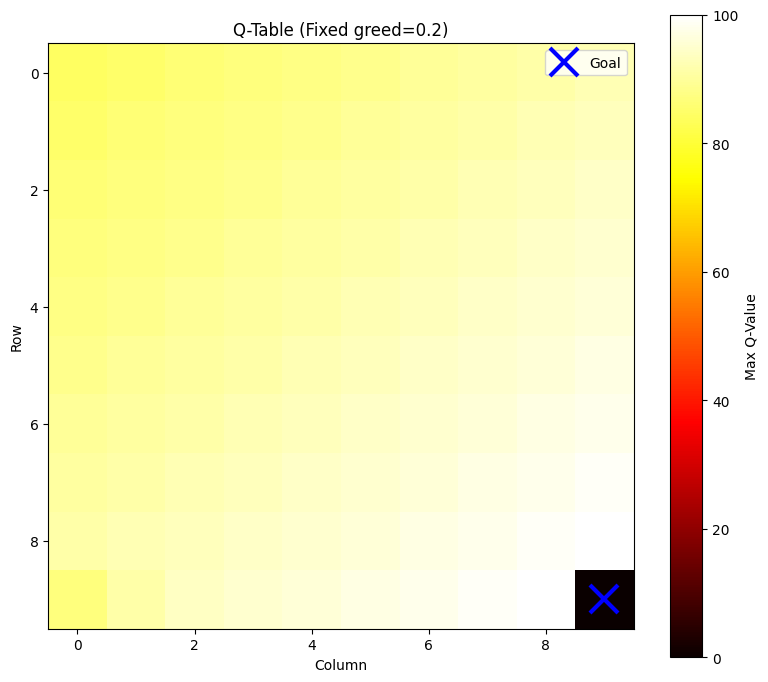

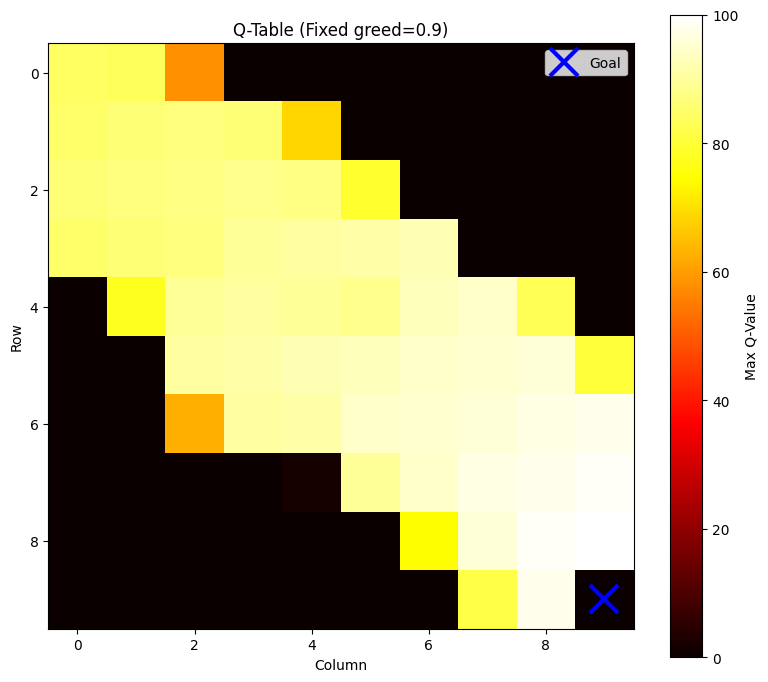

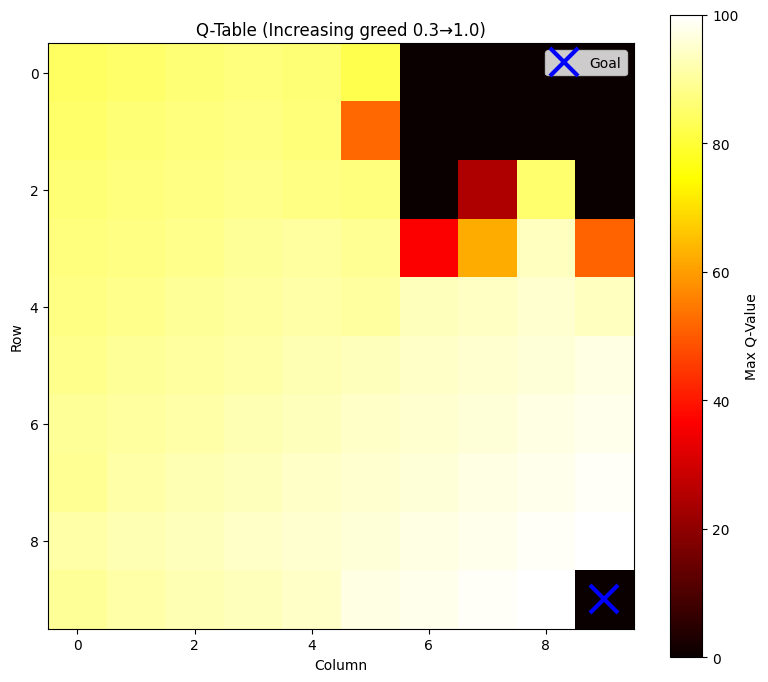

In [ ]:
# visualiuzar a Q-tables aprendidas

def visualize_q_table(agent, env, title="Learned Q-Values"):
    """Visualize Q-table as heatmap"""
    q_max = agent.get_q_max()
    q_grid = q_max[1:101].reshape(env.size, env.size)
    
    fig, ax = plt.subplots(figsize=(8, 7))
    im = ax.imshow(q_grid, cmap='hot', interpolation='nearest')
    
    # barra de cor
    plt.colorbar(im, ax=ax, label='Max Q-Value')
    
    # marcar o objetivo
    goal_row, goal_col = env.state_to_coords(env.goal_state)
    ax.plot(goal_col, goal_row, 'bx', markersize=20, markeredgewidth=3, label='Goal')
    
    ax.set_title(title)
    ax.set_xlabel('Column')
    ax.set_ylabel('Row')
    ax.legend()
    plt.tight_layout()
    plt.show()

# visualizar os diferentes valores de greed
print("\nVisualizing learned Q-tables...\n")

for greed in [0.2, 0.9]:
    np.random.seed(42)
    env = GridWorld(size=10, goal_state=100)
    agent = QLearningAgent(n_states=100, n_actions=4, alpha=0.7, gamma=0.99)
    train_qlearning(env, agent, 20000, greed=greed)
    visualize_q_table(agent, env, title=f"Q-Table (Fixed greed={greed})")

# aumento de greed
np.random.seed(42)
env = GridWorld(size=10, goal_state=100)
agent = QLearningAgent(n_states=100, n_actions=4, alpha=0.7, gamma=0.99)
train_qlearning_increasing_greed(env, agent, 20000, initial_greed=0.3)
visualize_q_table(agent, env, title="Q-Table (Increasing greed 0.3→1.0)")


## 4.

In [19]:
print("Exercise 4 - Adding walls to the environment\n")

# Define walls (example: create a maze-like structure)
walls = [
    13, 14, 15, 16, 17,  # Horizontal wall
    27, 37, 47, 57,      # Vertical wall
    73, 74, 75, 76, 77,  # Another horizontal wall
]

print(f"Number of walls: {len(walls)}")
print(f"Wall positions: {walls}\n")


Exercise 4 - Adding walls to the environment

Number of walls: 14
Wall positions: [13, 14, 15, 16, 17, 27, 37, 47, 57, 73, 74, 75, 76, 77]



### 4.1

In [20]:
results_with_walls = {greed: [] for greed in [0.5, 0.9]}
results_increasing_walls = []

print("Training with walls...\n")

# Test fixed greed values
for greed in [0.5, 0.9]:
    print(f"Testing greed={greed} with walls...")
    
    for seed in range(n_tests):
        np.random.seed(seed)
        env = GridWorld(size=10, goal_state=100, walls=walls)
        agent = QLearningAgent(n_states=100, n_actions=4, alpha=0.7, gamma=0.99)
        
        test_results = train_qlearning(env, agent, n_steps, greed=greed, test_points=test_points)
        results_with_walls[greed].append(test_results)
    
    print(f"  Completed {n_tests} runs\n")

# Test increasing greed
print("Testing increasing greed with walls...")
for seed in range(n_tests):
    np.random.seed(seed)
    env = GridWorld(size=10, goal_state=100, walls=walls)
    agent = QLearningAgent(n_states=100, n_actions=4, alpha=0.7, gamma=0.99)
    
    test_results = train_qlearning_increasing_greed(env, agent, n_steps, 
                                                     initial_greed=0.3,
                                                     test_points=test_points)
    results_increasing_walls.append(test_results)

print(f"Completed {n_tests} runs\n")


Training with walls...

Testing greed=0.5 with walls...
  Completed 30 runs

Testing greed=0.9 with walls...
  Completed 30 runs

Testing increasing greed with walls...
Completed 30 runs



### 4.2

C:\Users\Ana Maria Ribeiro\AppData\Local\Temp\ipykernel_1660\2164275009.py:92: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels)


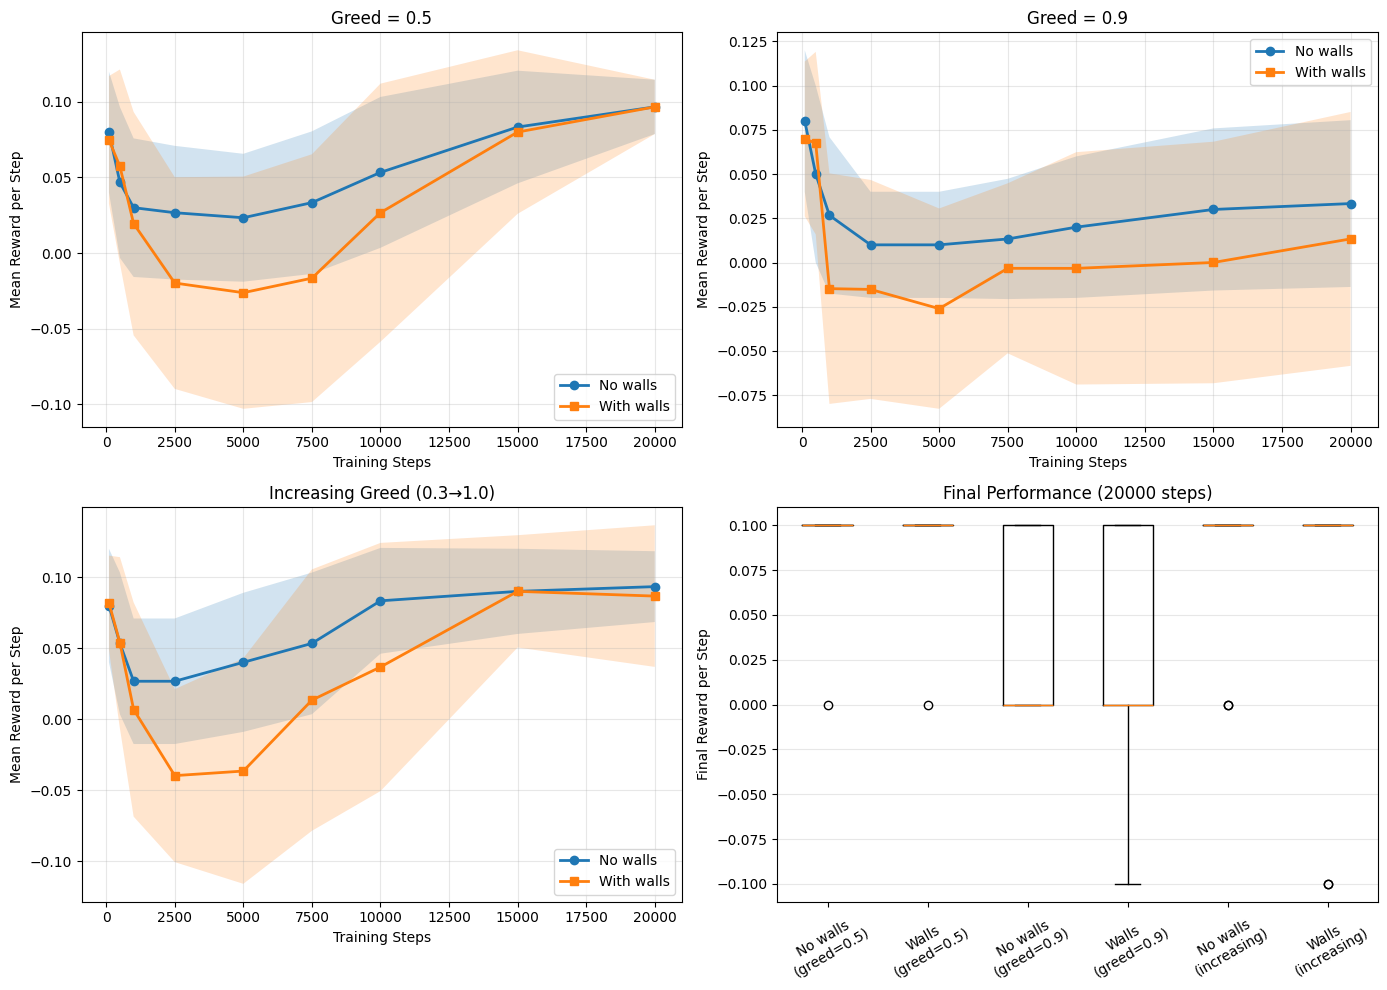


Final performance comparison:
Configuration                  Mean       Std       
--------------------------------------------------
No walls (greed=0.5)           0.0967    0.0180
Walls (greed=0.5)              0.0967    0.0180
No walls (greed=0.9)           0.0333    0.0471
Walls (greed=0.9)              0.0134    0.0718
No walls (increasing)          0.0933    0.0249
Walls (increasing)             0.0867    0.0499


In [21]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot for greed=0.5
ax = axes[0, 0]
for label, results, style in [('No walls', results_by_greed[0.5], 'o-'),
                               ('With walls', results_with_walls[0.5], 's-')]:
    rewards_by_step = {step: [] for step in test_points}
    for test_run in results:
        for step, reward in test_run:
            rewards_by_step[step].append(reward)
    
    steps = list(rewards_by_step.keys())
    means = [np.mean(rewards_by_step[s]) for s in steps]
    stds = [np.std(rewards_by_step[s]) for s in steps]
    
    ax.plot(steps, means, style, label=label, linewidth=2)
    ax.fill_between(steps,
                     np.array(means) - np.array(stds),
                     np.array(means) + np.array(stds),
                     alpha=0.2)

ax.set_xlabel('Training Steps')
ax.set_ylabel('Mean Reward per Step')
ax.set_title('Greed = 0.5')
ax.legend()
ax.grid(alpha=0.3)

# Plot for greed=0.9
ax = axes[0, 1]
for label, results, style in [('No walls', results_by_greed[0.9], 'o-'),
                               ('With walls', results_with_walls[0.9], 's-')]:
    rewards_by_step = {step: [] for step in test_points}
    for test_run in results:
        for step, reward in test_run:
            rewards_by_step[step].append(reward)
    
    steps = list(rewards_by_step.keys())
    means = [np.mean(rewards_by_step[s]) for s in steps]
    stds = [np.std(rewards_by_step[s]) for s in steps]
    
    ax.plot(steps, means, style, label=label, linewidth=2)
    ax.fill_between(steps,
                     np.array(means) - np.array(stds),
                     np.array(means) + np.array(stds),
                     alpha=0.2)

ax.set_xlabel('Training Steps')
ax.set_ylabel('Mean Reward per Step')
ax.set_title('Greed = 0.9')
ax.legend()
ax.grid(alpha=0.3)

# Plot for increasing greed
ax = axes[1, 0]
for label, results, style in [('No walls', results_increasing, 'o-'),
                               ('With walls', results_increasing_walls, 's-')]:
    rewards_by_step = {step: [] for step in test_points}
    for test_run in results:
        for step, reward in test_run:
            rewards_by_step[step].append(reward)
    
    steps = list(rewards_by_step.keys())
    means = [np.mean(rewards_by_step[s]) for s in steps]
    stds = [np.std(rewards_by_step[s]) for s in steps]
    
    ax.plot(steps, means, style, label=label, linewidth=2)
    ax.fill_between(steps,
                     np.array(means) - np.array(stds),
                     np.array(means) + np.array(stds),
                     alpha=0.2)

ax.set_xlabel('Training Steps')
ax.set_ylabel('Mean Reward per Step')
ax.set_title('Increasing Greed (0.3→1.0)')
ax.legend()
ax.grid(alpha=0.3)

# Final performance comparison
ax = axes[1, 1]
labels = ['No walls\n(greed=0.5)', 'Walls\n(greed=0.5)', 
          'No walls\n(greed=0.9)', 'Walls\n(greed=0.9)',
          'No walls\n(increasing)', 'Walls\n(increasing)']
data = [
    [test_run[-1][1] for test_run in results_by_greed[0.5]],
    [test_run[-1][1] for test_run in results_with_walls[0.5]],
    [test_run[-1][1] for test_run in results_by_greed[0.9]],
    [test_run[-1][1] for test_run in results_with_walls[0.9]],
    [test_run[-1][1] for test_run in results_increasing],
    [test_run[-1][1] for test_run in results_increasing_walls]
]

ax.boxplot(data, labels=labels)
ax.set_ylabel('Final Reward per Step')
ax.set_title('Final Performance (20000 steps)')
ax.grid(alpha=0.3, axis='y')
ax.tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()

print("\nFinal performance comparison:")
print(f"{'Configuration':<30} {'Mean':<10} {'Std':<10}")
print("-" * 50)
for i, label in enumerate(labels):
    mean_reward = np.mean(data[i])
    std_reward = np.std(data[i])
    print(f"{label.replace(chr(10), ' '):<30} {mean_reward:.4f}    {std_reward:.4f}")


### 4.3


Visualizing learned Q-tables with walls...



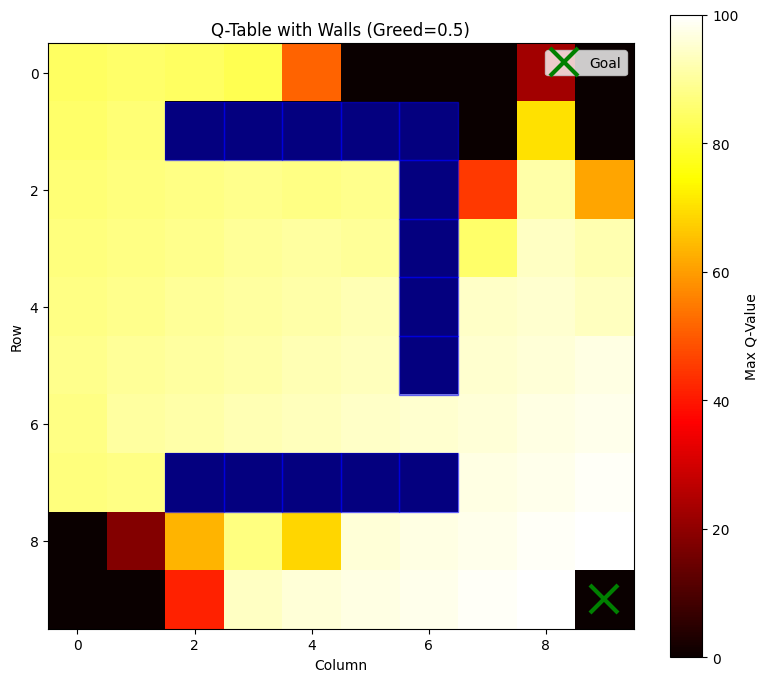

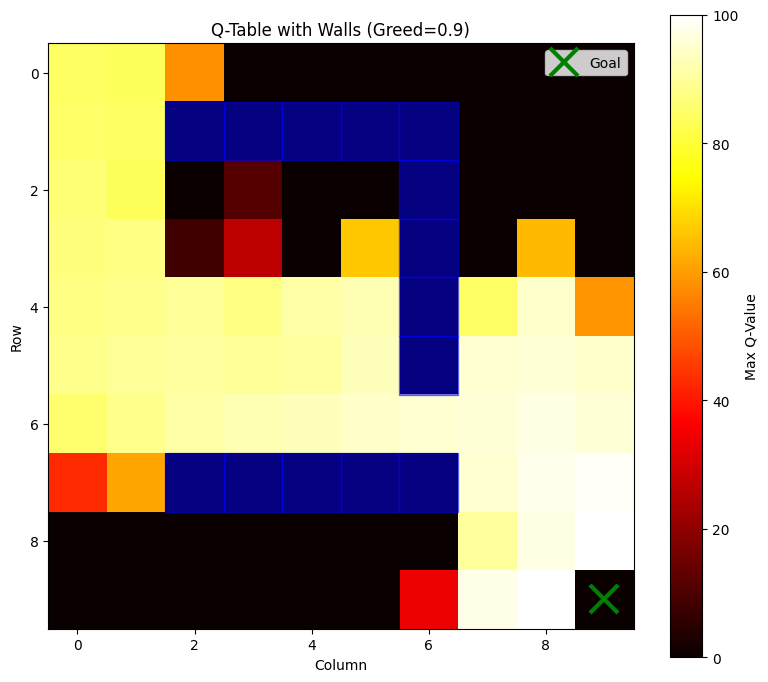

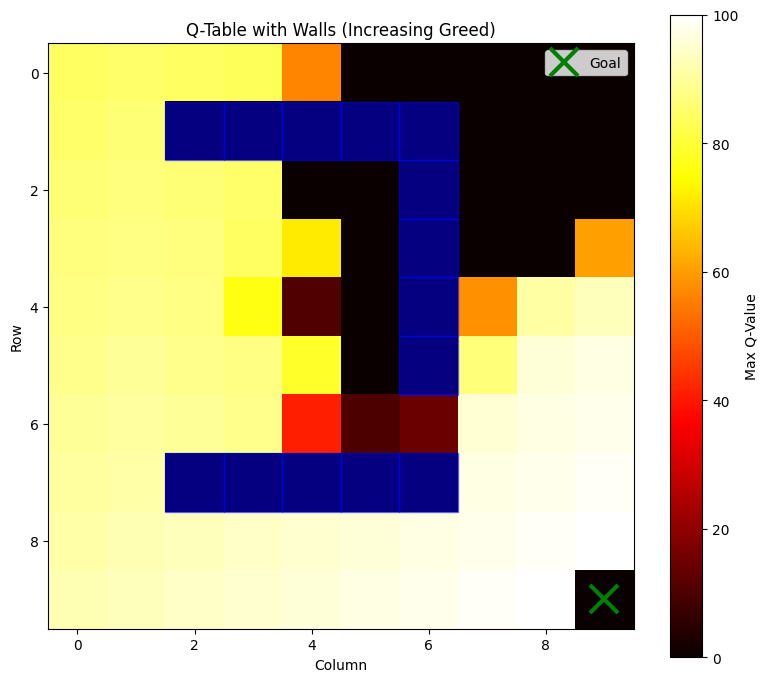

In [22]:
def visualize_q_table_with_walls(agent, env, title="Learned Q-Values with Walls"):
    """Visualize Q-table with walls marked"""
    q_max = agent.get_q_max()
    q_grid = q_max[1:101].reshape(env.size, env.size)
    
    fig, ax = plt.subplots(figsize=(8, 7))
    im = ax.imshow(q_grid, cmap='hot', interpolation='nearest')
    
    # Mark walls
    for wall in env.walls:
        wall_row, wall_col = env.state_to_coords(wall)
        ax.add_patch(plt.Rectangle((wall_col-0.5, wall_row-0.5), 1, 1, 
                                    fill=True, color='blue', alpha=0.5))
    
    # Mark goal
    goal_row, goal_col = env.state_to_coords(env.goal_state)
    ax.plot(goal_col, goal_row, 'gx', markersize=20, markeredgewidth=3, label='Goal')
    
    # Add colorbar
    plt.colorbar(im, ax=ax, label='Max Q-Value')
    
    ax.set_title(title)
    ax.set_xlabel('Column')
    ax.set_ylabel('Row')
    ax.legend()
    plt.tight_layout()
    plt.show()

print("\nVisualizing learned Q-tables with walls...\n")

# Train and visualize with different strategies
for greed, title_suffix in [(0.5, "Greed=0.5"), (0.9, "Greed=0.9")]:
    np.random.seed(42)
    env = GridWorld(size=10, goal_state=100, walls=walls)
    agent = QLearningAgent(n_states=100, n_actions=4, alpha=0.7, gamma=0.99)
    train_qlearning(env, agent, 20000, greed=greed)
    visualize_q_table_with_walls(agent, env, title=f"Q-Table with Walls ({title_suffix})")

# Increasing greed
np.random.seed(42)
env = GridWorld(size=10, goal_state=100, walls=walls)
agent = QLearningAgent(n_states=100, n_actions=4, alpha=0.7, gamma=0.99)
train_qlearning_increasing_greed(env, agent, 20000, initial_greed=0.3)
visualize_q_table_with_walls(agent, env, title="Q-Table with Walls (Increasing Greed)")


# Exercício 4 - corrigido

In [ ]:
print("Exercise 4 - Adding walls to the environment\n")

# Define walls based on grid pattern:
# S O O X O O O O O O  (row 0: states 1-10)
# O O O X O O X O O O  (row 1: states 11-20)
# O O O X O O X O O O  (row 2: states 21-30)
# O O O X O O X O O O  (row 3: states 31-40)
# O O O X O O X O O O  (row 4: states 41-50)
# O O O X O O X O O O  (row 5: states 51-60)
# O O O X O O X O O O  (row 6: states 61-70)
# O O O X O O X O O O  (row 7: states 71-80)
# O O O X O O X O O O  (row 8: states 81-90)
# O O O O O O X O O E  (row 9: states 91-100)

print("S O O X O O O O O O\nO O O X O O X O O O\nO O O X O O X O O O\nO O O X O O X O O O\nO O O X O O X O O O\nO O O X O O X O O O\nO O O X O O X O O O\nO O O X O O X O O O\nO O O X O O X O O O\nO O O O O O X O O E\n\n")

walls = [
    # Column 3 (states 4, 14, 24, ..., 84) - vertical wall
    4, 14, 24, 34, 44, 54, 64, 74, 84,
    # Column 6 (states 17, 27, 37, ..., 97) - vertical wall
    17, 27, 37, 47, 57, 67, 77, 87, 97,
]

print(f"Number of walls: {len(walls)}")
print("Wall configuration:")
print("  Vertical wall at column 3 (states 4, 14, 24, ...)")
print("  Vertical wall at column 6 (states 17, 27, 37, ...)")
print(f"  Start: state 1, Goal: state 100\n")

Exercise 4 - Adding walls to the environment

S O O X O O O O O O
O O O X O O X O O O
O O O X O O X O O O
O O O X O O X O O O
O O O X O O X O O O
O O O X O O X O O O
O O O X O O X O O O
O O O X O O X O O O
O O O X O O X O O O
O O O O O O X O O E


Number of walls: 18
Wall configuration:
  Vertical wall at column 3 (states 4, 14, 24, ...)
  Vertical wall at column 6 (states 17, 27, 37, ...)
  Start: state 1, Goal: state 100



# 4.1

In [ ]:
results_with_walls = {greed: [] for greed in [0.5, 0.9]}
results_increasing_walls = []

print("Training with walls...\n")

# testar com valores fixos de greed
for greed in [0.5, 0.9]:
    print(f"Testing greed={greed} with walls...")
    
    for seed in range(n_tests):
        np.random.seed(seed)
        env = GridWorld(size=10, goal_state=100, walls=walls)
        agent = QLearningAgent(n_states=100, n_actions=4, alpha=0.7, gamma=0.99)
        
        test_results = train_qlearning(env, agent, n_steps, greed=greed, test_points=test_points)
        results_with_walls[greed].append(test_results)
    
    print(f"  Completed {n_tests} runs\n")

# testar com a increasing greed
print("Testing increasing greed with walls...")
for seed in range(n_tests):
    np.random.seed(seed)
    env = GridWorld(size=10, goal_state=100, walls=walls)
    agent = QLearningAgent(n_states=100, n_actions=4, alpha=0.7, gamma=0.99)
    
    test_results = train_qlearning_increasing_greed(env, agent, n_steps, 
                                                     initial_greed=0.3,
                                                     test_points=test_points)
    results_increasing_walls.append(test_results)

print(f"Completed {n_tests} runs\n")

Training with walls...

Testing greed=0.5 with walls...
  Completed 30 runs

Testing greed=0.9 with walls...
  Completed 30 runs

Testing increasing greed with walls...
Completed 30 runs



# 4.2

C:\Users\Ana Maria Ribeiro\AppData\Local\Temp\ipykernel_1660\4028815684.py:92: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels)


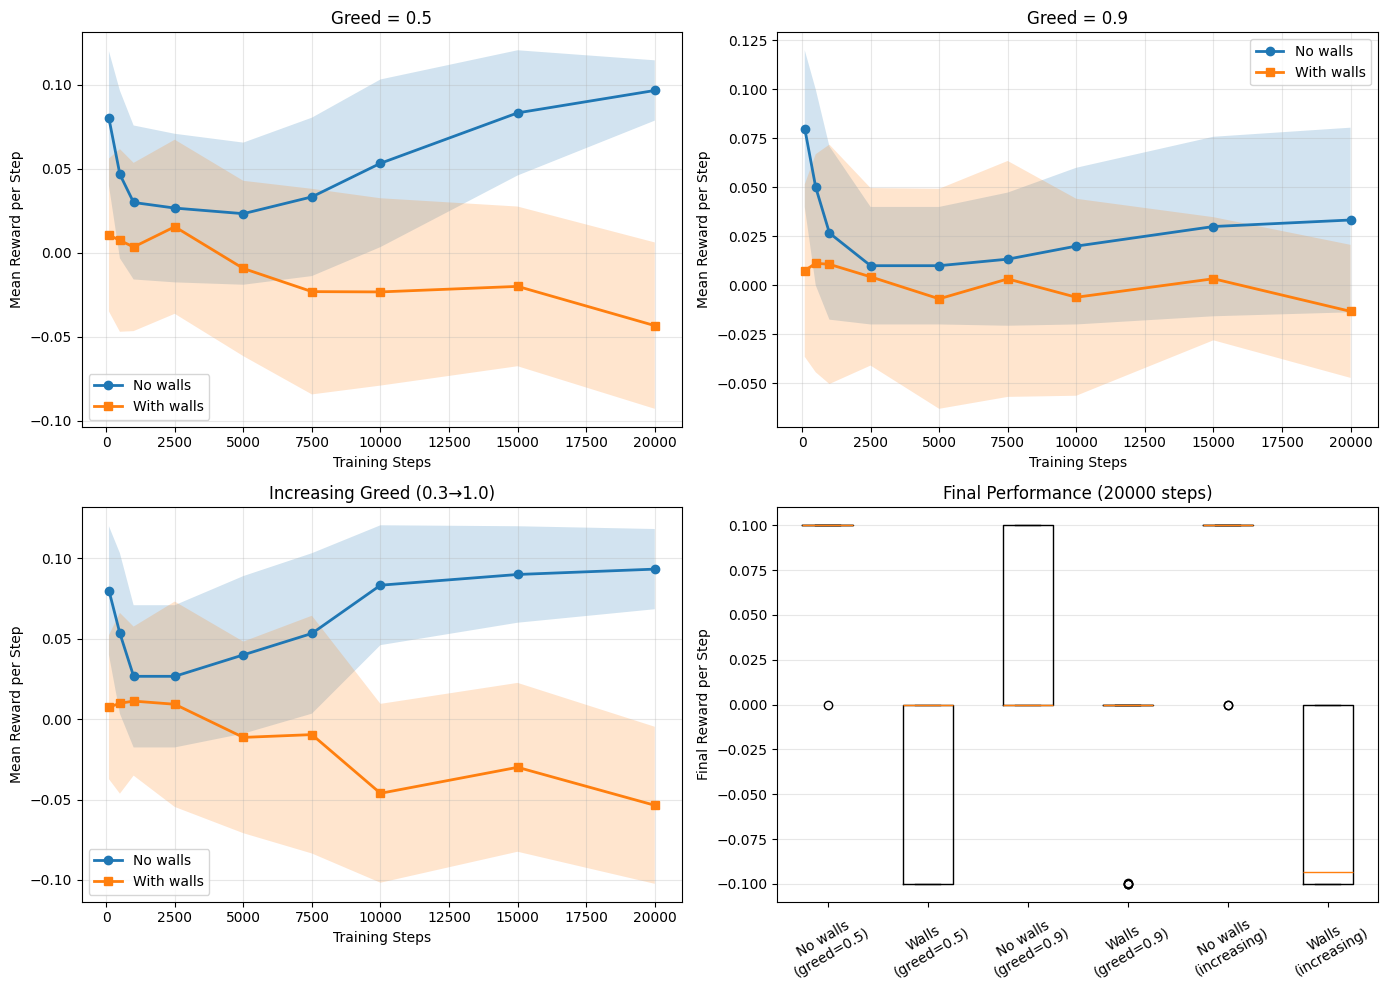


Final performance comparison:
Configuration                  Mean       Std       
--------------------------------------------------
No walls (greed=0.5)           0.0967    0.0180
Walls (greed=0.5)              -0.0433    0.0495
No walls (greed=0.9)           0.0333    0.0471
Walls (greed=0.9)              -0.0133    0.0340
No walls (increasing)          0.0933    0.0249
Walls (increasing)             -0.0535    0.0488


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# plot da greed=0.5
ax = axes[0, 0]
for label, results, style in [('No walls', results_by_greed[0.5], 'o-'),
                               ('With walls', results_with_walls[0.5], 's-')]:
    rewards_by_step = {step: [] for step in test_points}
    for test_run in results:
        for step, reward in test_run:
            rewards_by_step[step].append(reward)
    
    steps = list(rewards_by_step.keys())
    means = [np.mean(rewards_by_step[s]) for s in steps]
    stds = [np.std(rewards_by_step[s]) for s in steps]
    
    ax.plot(steps, means, style, label=label, linewidth=2)
    ax.fill_between(steps,
                     np.array(means) - np.array(stds),
                     np.array(means) + np.array(stds),
                     alpha=0.2)

ax.set_xlabel('Training Steps')
ax.set_ylabel('Mean Reward per Step')
ax.set_title('Greed = 0.5')
ax.legend()
ax.grid(alpha=0.3)

# plot da greed=0.9
ax = axes[0, 1]
for label, results, style in [('No walls', results_by_greed[0.9], 'o-'),
                               ('With walls', results_with_walls[0.9], 's-')]:
    rewards_by_step = {step: [] for step in test_points}
    for test_run in results:
        for step, reward in test_run:
            rewards_by_step[step].append(reward)
    
    steps = list(rewards_by_step.keys())
    means = [np.mean(rewards_by_step[s]) for s in steps]
    stds = [np.std(rewards_by_step[s]) for s in steps]
    
    ax.plot(steps, means, style, label=label, linewidth=2)
    ax.fill_between(steps,
                     np.array(means) - np.array(stds),
                     np.array(means) + np.array(stds),
                     alpha=0.2)

ax.set_xlabel('Training Steps')
ax.set_ylabel('Mean Reward per Step')
ax.set_title('Greed = 0.9')
ax.legend()
ax.grid(alpha=0.3)

# plot da increasing greed
ax = axes[1, 0]
for label, results, style in [('No walls', results_increasing, 'o-'),
                               ('With walls', results_increasing_walls, 's-')]:
    rewards_by_step = {step: [] for step in test_points}
    for test_run in results:
        for step, reward in test_run:
            rewards_by_step[step].append(reward)
    
    steps = list(rewards_by_step.keys())
    means = [np.mean(rewards_by_step[s]) for s in steps]
    stds = [np.std(rewards_by_step[s]) for s in steps]
    
    ax.plot(steps, means, style, label=label, linewidth=2)
    ax.fill_between(steps,
                     np.array(means) - np.array(stds),
                     np.array(means) + np.array(stds),
                     alpha=0.2)

ax.set_xlabel('Training Steps')
ax.set_ylabel('Mean Reward per Step')
ax.set_title('Increasing Greed (0.3→1.0)')
ax.legend()
ax.grid(alpha=0.3)

# comparação final da performance
ax = axes[1, 1]
labels = ['No walls\n(greed=0.5)', 'Walls\n(greed=0.5)', 
          'No walls\n(greed=0.9)', 'Walls\n(greed=0.9)',
          'No walls\n(increasing)', 'Walls\n(increasing)']
data = [
    [test_run[-1][1] for test_run in results_by_greed[0.5]],
    [test_run[-1][1] for test_run in results_with_walls[0.5]],
    [test_run[-1][1] for test_run in results_by_greed[0.9]],
    [test_run[-1][1] for test_run in results_with_walls[0.9]],
    [test_run[-1][1] for test_run in results_increasing],
    [test_run[-1][1] for test_run in results_increasing_walls]
]

ax.boxplot(data, labels=labels)
ax.set_ylabel('Final Reward per Step')
ax.set_title('Final Performance (20000 steps)')
ax.grid(alpha=0.3, axis='y')
ax.tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()

print("\nFinal performance comparison:")
print(f"{'Configuration':<30} {'Mean':<10} {'Std':<10}")
print("-" * 50)
for i, label in enumerate(labels):
    mean_reward = np.mean(data[i])
    std_reward = np.std(data[i])
    print(f"{label.replace(chr(10), ' '):<30} {mean_reward:.4f}    {std_reward:.4f}")

# 4.3


Visualizing learned Q-tables with walls...



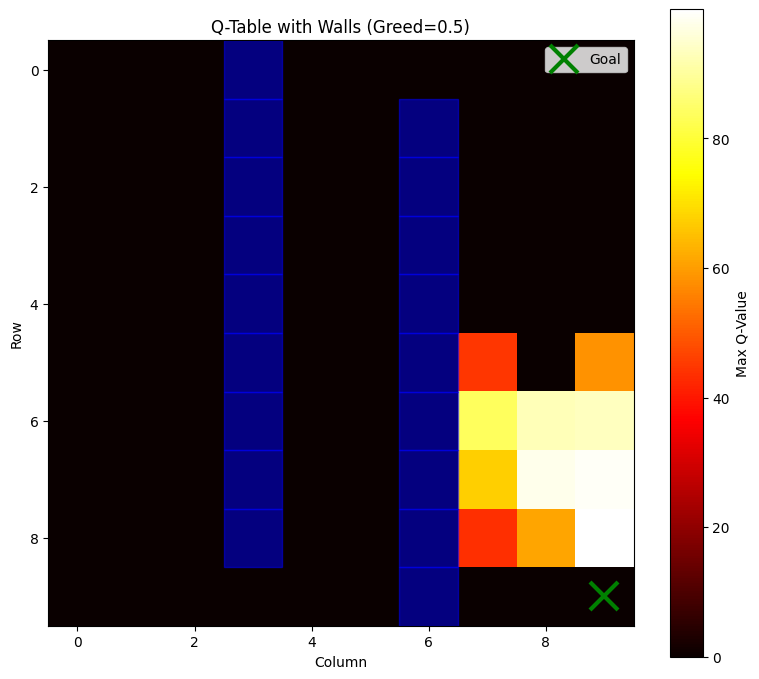

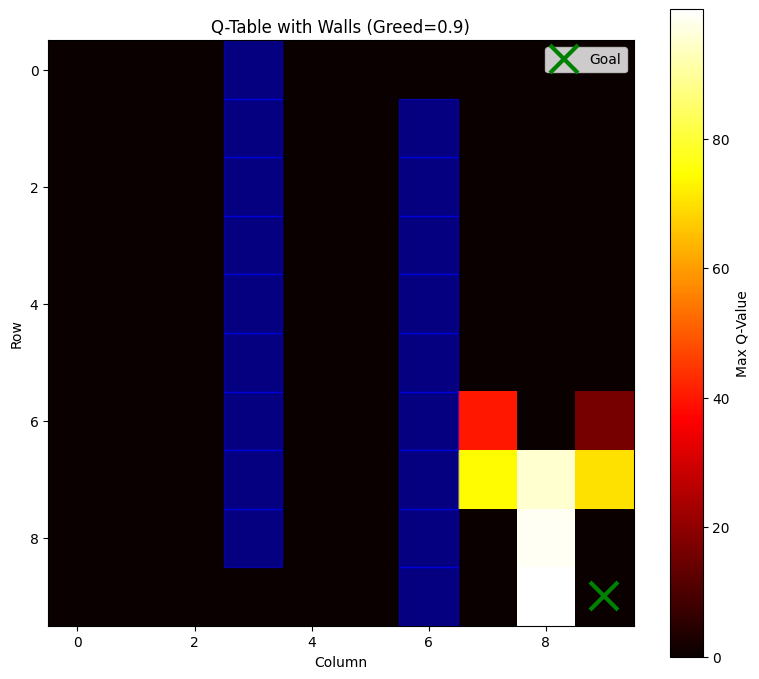

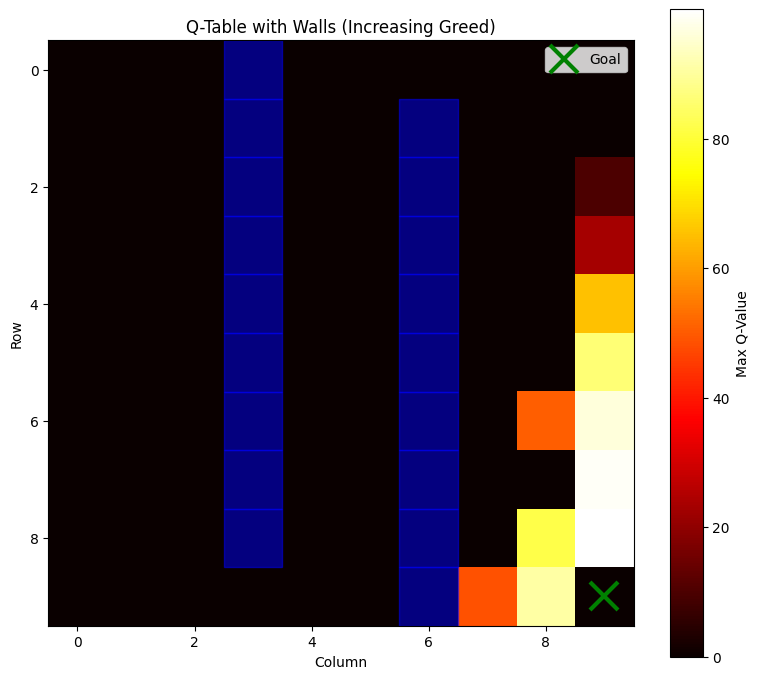


CONCLUSIONS

Exercise 3 - Epsilon-Greedy Strategies:
- Low greed (0.2): More exploration, slower convergence
- High greed (0.9): Faster learning, risk of suboptimal policy
- Increasing greed: Best balance - explores early, exploits later
- Recommendation: Use increasing greed for best results

Exercise 4 - Impact of Walls:
- Walls add complexity to the environment
- Penalty for hitting walls (-0.1) guides learning
- Agent learns to navigate around obstacles
- Slightly slower convergence compared to no walls
- Final performance depends on wall configuration
- More exploration (lower greed) may be beneficial with walls


In [ ]:
def visualize_q_table_with_walls(agent, env, title="Learned Q-Values with Walls"):
    """Visualize Q-table with walls marked"""
    q_max = agent.get_q_max()
    q_grid = q_max[1:101].reshape(env.size, env.size)
    
    fig, ax = plt.subplots(figsize=(8, 7))
    im = ax.imshow(q_grid, cmap='hot', interpolation='nearest')
    
    # marcar as paredes
    for wall in env.walls:
        wall_row, wall_col = env.state_to_coords(wall)
        ax.add_patch(plt.Rectangle((wall_col-0.5, wall_row-0.5), 1, 1, 
                                    fill=True, color='blue', alpha=0.5))
    
    # marcar o objetivo
    goal_row, goal_col = env.state_to_coords(env.goal_state)
    ax.plot(goal_col, goal_row, 'gx', markersize=20, markeredgewidth=3, label='Goal')
    
    # adicionar barra de cor
    plt.colorbar(im, ax=ax, label='Max Q-Value')
    
    ax.set_title(title)
    ax.set_xlabel('Column')
    ax.set_ylabel('Row')
    ax.legend()
    plt.tight_layout()
    plt.show()

print("\nVisualizing learned Q-tables with walls...\n")

# treinar e visualizar com diferentes estratégias
for greed, title_suffix in [(0.5, "Greed=0.5"), (0.9, "Greed=0.9")]:
    np.random.seed(42)
    env = GridWorld(size=10, goal_state=100, walls=walls)
    agent = QLearningAgent(n_states=100, n_actions=4, alpha=0.7, gamma=0.99)
    train_qlearning(env, agent, 20000, greed=greed)
    visualize_q_table_with_walls(agent, env, title=f"Q-Table with Walls ({title_suffix})")

# increasing greed
np.random.seed(42)
env = GridWorld(size=10, goal_state=100, walls=walls)
agent = QLearningAgent(n_states=100, n_actions=4, alpha=0.7, gamma=0.99)
train_qlearning_increasing_greed(env, agent, 20000, initial_greed=0.3)
visualize_q_table_with_walls(agent, env, title="Q-Table with Walls (Increasing Greed)")


print("\n" + "="*60)
print("CONCLUSIONS")
print("="*60)

print("\nExercise 3 - Epsilon-Greedy Strategies:")
print("- Low greed (0.2): More exploration, slower convergence")
print("- High greed (0.9): Faster learning, risk of suboptimal policy")
print("- Increasing greed: Best balance - explores early, exploits later")
print("- Recommendation: Use increasing greed for best results")

print("\nExercise 4 - Impact of Walls:")
print("- Walls add complexity to the environment")
print("- Penalty for hitting walls (-0.1) guides learning")
print("- Agent learns to navigate around obstacles")
print("- Slightly slower convergence compared to no walls")
print("- Final performance depends on wall configuration")
print("- More exploration (lower greed) may be beneficial with walls")

# Exercício 5


EXERCISE 5 - NON-DETERMINISTIC ENVIRONMENT

Testing stochastic environment (5% probability of random action)...

Training agents in stochastic environment...
Completed 30 runs



C:\Users\Ana Maria Ribeiro\AppData\Local\Temp\ipykernel_1660\830592325.py:78: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(data, labels=['Deterministic', 'Stochastic\n(5%)'])


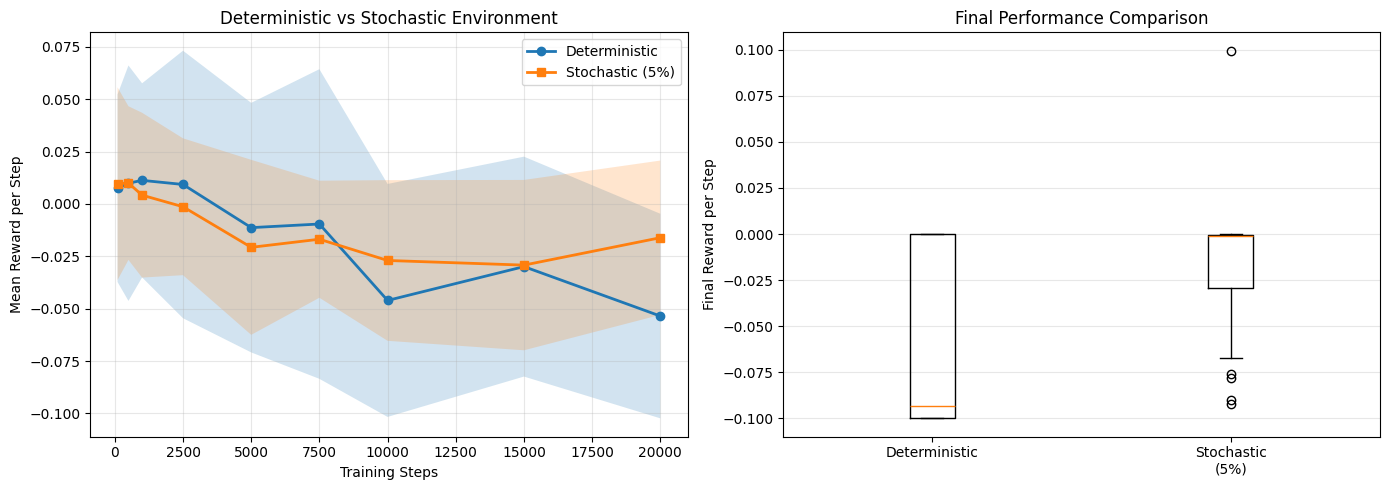


Comparison Results:
Environment          Mean Reward     Std Dev
--------------------------------------------------
Deterministic        -0.0535         0.0488
Stochastic (5%)      -0.0161         0.0368

Observations:
- Stochastic environment has higher variance in performance
- Agent needs more exploration to handle uncertainty
- Q-values become more averaged due to stochastic transitions
- Final policy may be more robust but slightly less optimal
- Convergence is slower due to noisy feedback


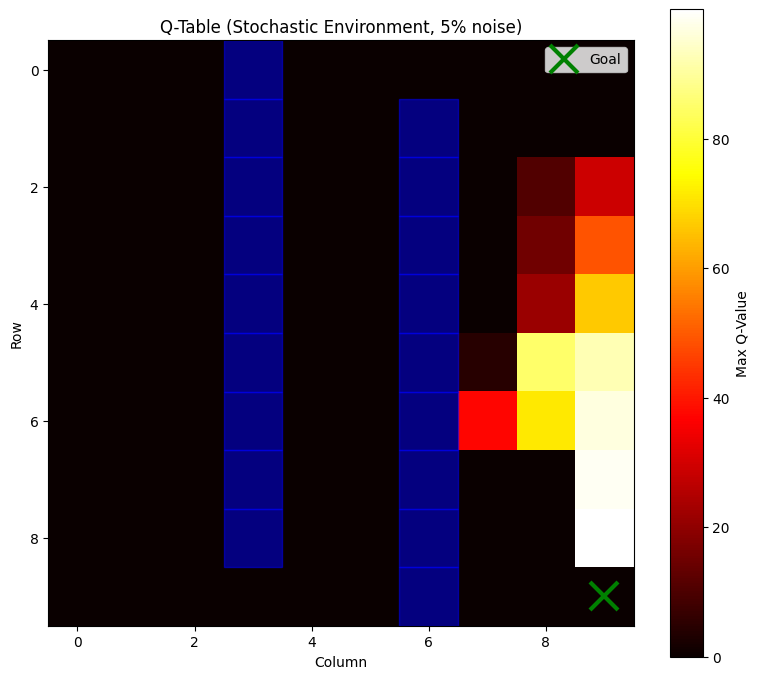

In [31]:
print("\n" + "="*60)
print("EXERCISE 5 - NON-DETERMINISTIC ENVIRONMENT")
print("="*60 + "\n")

class StochasticGridWorld(GridWorld):
    def __init__(self, size=10, goal_state=100, walls=None, stochasticity=0.05):
        super().__init__(size, goal_state, walls)
        self.stochasticity = stochasticity
    
    def transition(self, state, action):
        """
        State transition with stochasticity.
        With probability stochasticity, move to random neighbor instead.
        """
        # With probability stochasticity, choose random action
        if np.random.random() < self.stochasticity:
            action = self.actions[np.random.randint(len(self.actions))]
        
        # Normal transition
        return super().transition(state, action)

print("Testing stochastic environment (5% probability of random action)...\n")

# Compare deterministic vs stochastic
stochastic_results = []
n_tests = 30
n_steps = 20000
test_points = [100, 500, 1000, 2500, 5000, 7500, 10000, 15000, 20000]

print("Training agents in stochastic environment...")
for seed in range(n_tests):
    np.random.seed(seed)
    env = StochasticGridWorld(size=10, goal_state=100, walls=walls, stochasticity=0.05)
    agent = QLearningAgent(n_states=100, n_actions=4, alpha=0.7, gamma=0.99)
    
    test_results = train_qlearning_increasing_greed(env, agent, n_steps, 
                                                     initial_greed=0.3,
                                                     test_points=test_points)
    stochastic_results.append(test_results)

print(f"Completed {n_tests} runs\n")

# %% [markdown]
# ### Compare deterministic vs stochastic

# %%
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot learning curves
for label, results, style in [('Deterministic', results_increasing_walls, 'o-'),
                               ('Stochastic (5%)', stochastic_results, 's-')]:
    rewards_by_step = {step: [] for step in test_points}
    for test_run in results:
        for step, reward in test_run:
            rewards_by_step[step].append(reward)
    
    steps = list(rewards_by_step.keys())
    means = [np.mean(rewards_by_step[s]) for s in steps]
    stds = [np.std(rewards_by_step[s]) for s in steps]
    
    ax1.plot(steps, means, style, label=label, linewidth=2)
    ax1.fill_between(steps,
                     np.array(means) - np.array(stds),
                     np.array(means) + np.array(stds),
                     alpha=0.2)

ax1.set_xlabel('Training Steps')
ax1.set_ylabel('Mean Reward per Step')
ax1.set_title('Deterministic vs Stochastic Environment')
ax1.legend()
ax1.grid(alpha=0.3)

# Final performance comparison
data = [
    [test_run[-1][1] for test_run in results_increasing_walls],
    [test_run[-1][1] for test_run in stochastic_results]
]
ax2.boxplot(data, labels=['Deterministic', 'Stochastic\n(5%)'])
ax2.set_ylabel('Final Reward per Step')
ax2.set_title('Final Performance Comparison')
ax2.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nComparison Results:")
print(f"{'Environment':<20} {'Mean Reward':<15} {'Std Dev'}")
print("-" * 50)

det_rewards = [test_run[-1][1] for test_run in results_increasing_walls]
stoch_rewards = [test_run[-1][1] for test_run in stochastic_results]

print(f"{'Deterministic':<20} {np.mean(det_rewards):.4f}         {np.std(det_rewards):.4f}")
print(f"{'Stochastic (5%)':<20} {np.mean(stoch_rewards):.4f}         {np.std(stoch_rewards):.4f}")

print("\nObservations:")
print("- Stochastic environment has higher variance in performance")
print("- Agent needs more exploration to handle uncertainty")
print("- Q-values become more averaged due to stochastic transitions")
print("- Final policy may be more robust but slightly less optimal")
print("- Convergence is slower due to noisy feedback")

# Visualize Q-table learned in stochastic environment
np.random.seed(42)
env = StochasticGridWorld(size=10, goal_state=100, walls=walls, stochasticity=0.05)
agent = QLearningAgent(n_states=100, n_actions=4, alpha=0.7, gamma=0.99)
train_qlearning_increasing_greed(env, agent, 20000, initial_greed=0.3)
visualize_q_table_with_walls(agent, env, title="Q-Table (Stochastic Environment, 5% noise)")

# Exercício 6


EXERCISE 6 - CONTINUOUS STATE SPACE

Testing continuous perception system...

Example perceptions:
State    Perception (up, left, down, right)       Discretized          Index
------------------------------------------------------------------------------------------
1        (0.00, 0.00, 9.00, 2.00)                 (0, 0, 4, 1)         360
12       (1.00, 1.00, 8.00, 1.00)                 (0, 0, 4, 0)         144
22       (2.00, 1.00, 7.00, 1.00)                 (1, 0, 3, 0)         109
50       (4.00, 2.00, 5.00, 0.00)                 (2, 1, 2, 0)         80
89       (8.00, 1.00, 1.00, 1.00)                 (4, 0, 0, 0)         4
100      (9.00, 2.00, 0.00, 0.00)                 (4, 1, 0, 0)         10

RISKS AND CHALLENGES

1. STATE ALIASING:
   - Different physical states may have same perception
   - Example: States in columns 2 and 8 (symmetric positions)
   - Both see similar wall distances but require different actions
   - This creates ambiguity in the Q-table

2. DIMENSIONALI

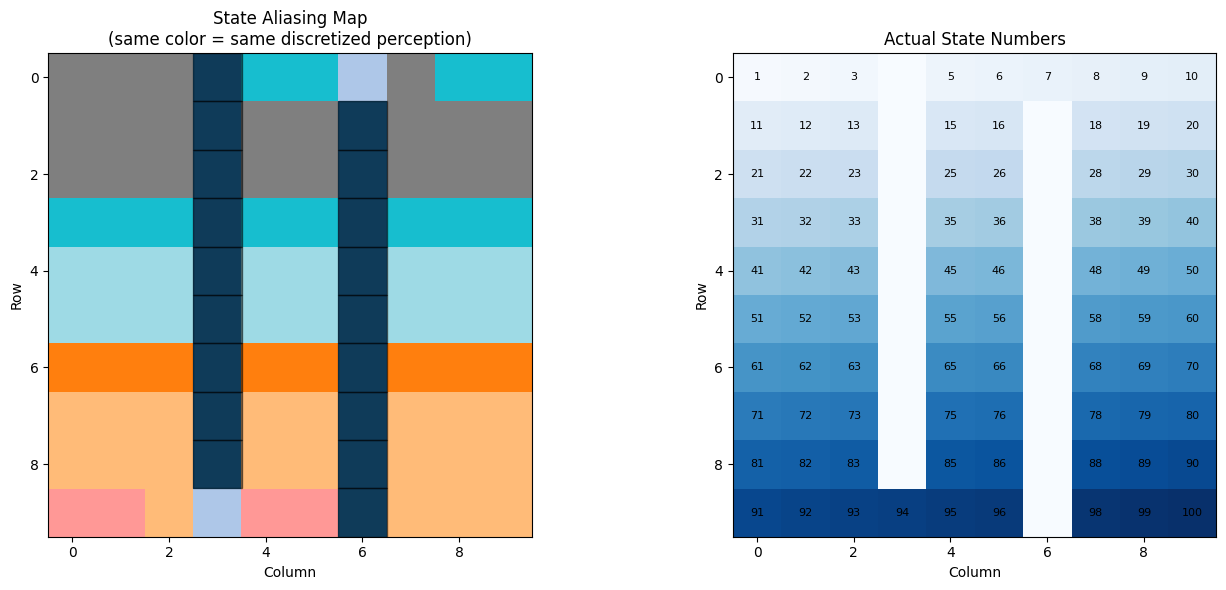


SOLUTIONS TO ALIASING PROBLEM

1. FUNCTION APPROXIMATION:
   - Use neural networks instead of Q-table
   - Can learn continuous state representations
   - Examples: Deep Q-Networks (DQN)

2. FEATURE ENGINEERING:
   - Add more informative features
   - Include position estimates, movement history
   - Break symmetries with additional sensors

3. MEMORY/HISTORY:
   - Use recurrent networks (LSTM, GRU)
   - Remember past observations
   - Partially Observable Markov Decision Process (POMDP)

4. FINER DISCRETIZATION:
   - More bins for better resolution
   - Trade-off: needs more training data
   - Adaptive discretization based on importance

5. TILE CODING:
   - Multiple overlapping discretizations
   - Reduces aliasing while keeping state space manageable
   - Common in continuous control tasks


In [32]:
print("\n" + "="*60)
print("EXERCISE 6 - CONTINUOUS STATE SPACE")
print("="*60 + "\n")

class ContinuousStateGridWorld(GridWorld):
    def __init__(self, size=10, goal_state=100, walls=None):
        super().__init__(size, goal_state, walls)
        self.cell_size = 1.0  # Each cell is 1 meter
    
    def get_perception(self, state):
        """
        Get agent's perception: distances to walls in each direction.
        Returns (up, left, down, right) distances.
        NA means no wall in that direction within reasonable distance.
        """
        row, col = self.state_to_coords(state)
        perceptions = []
        
        # Check each direction
        directions = [
            (-1, 0, 'up'),      # up
            (0, -1, 'left'),    # left
            (1, 0, 'down'),     # down
            (0, 1, 'right')     # right
        ]
        
        for dr, dc, name in directions:
            distance = self._distance_to_wall(row, col, dr, dc)
            perceptions.append(distance)
        
        return tuple(perceptions)
    
    def _distance_to_wall(self, row, col, dr, dc):
        """
        Calculate distance to wall in given direction.
        Returns distance in meters, or None if no wall found.
        """
        current_row, current_col = row, col
        distance = 0.0
        max_distance = self.size * self.cell_size
        
        while distance < max_distance:
            current_row += dr
            current_col += dc
            distance += self.cell_size
            
            # Check boundaries
            if current_row < 0 or current_row >= self.size:
                return distance - self.cell_size
            if current_col < 0 or current_col >= self.size:
                return distance - self.cell_size
            
            # Check walls
            check_state = self.coords_to_state(current_row, current_col)
            if check_state in self.walls:
                return distance - self.cell_size
        
        return None  # No wall found

def discretize_perception(perception, bins=5):
    """
    Discretize continuous perception into bins.
    This creates a simplified state representation.
    """
    discretized = []
    max_distance = 10.0
    
    for dist in perception:
        if dist is None:
            discretized.append(bins)  # Special bin for "no wall"
        else:
            # Bin the distance
            bin_idx = min(int(dist / max_distance * bins), bins - 1)
            discretized.append(bin_idx)
    
    return tuple(discretized)

def perception_to_state_index(perception, bins=5):
    """
    Convert perception tuple to single state index.
    Warning: This can create aliasing issues!
    """
    discretized = discretize_perception(perception, bins)
    
    # Convert to single number (base conversion)
    base = bins + 1  # +1 for "no wall" bin
    index = 0
    for i, value in enumerate(discretized):
        index += value * (base ** i)
    
    return index

# Test perception system
print("Testing continuous perception system...\n")

env = ContinuousStateGridWorld(size=10, goal_state=100, walls=walls)

# Test a few states
test_states = [1, 12, 22, 50, 89, 100]
print("Example perceptions:")
print(f"{'State':<8} {'Perception (up, left, down, right)':<40} {'Discretized':<20} {'Index'}")
print("-" * 90)

for state in test_states:
    perception = env.get_perception(state)
    discretized = discretize_perception(perception, bins=5)
    index = perception_to_state_index(perception, bins=5)
    
    # Format perception (None as 'NA')
    perc_str = '(' + ', '.join([f'{p:.2f}' if p is not None else 'NA' for p in perception]) + ')'
    print(f"{state:<8} {perc_str:<40} {str(discretized):<20} {index}")

print("\n" + "="*60)
print("RISKS AND CHALLENGES")
print("="*60)

print("\n1. STATE ALIASING:")
print("   - Different physical states may have same perception")
print("   - Example: States in columns 2 and 8 (symmetric positions)")
print("   - Both see similar wall distances but require different actions")
print("   - This creates ambiguity in the Q-table")

print("\n2. DIMENSIONALITY:")
print("   - Continuous state space is much larger")
print(f"   - With 5 bins per direction: (5+1)^4 = {6**4} possible states")
print("   - Many more states than original 100")
print("   - Sparse data problem: many states rarely visited")

print("\n3. RESOLUTION TRADE-OFF:")
print("   - Fine discretization: more states, sparse learning")
print("   - Coarse discretization: fewer states, more aliasing")
print("   - Need to balance precision vs learning efficiency")

print("\n4. SYMMETRY PROBLEMS:")
row, col = env.state_to_coords(22)  # Column 2
perc_22 = env.get_perception(22)
disc_22 = discretize_perception(perc_22)

row, col = env.state_to_coords(28)  # Column 8
perc_28 = env.get_perception(28)
disc_28 = discretize_perception(perc_28)

print(f"\n   State 22 perception: {perc_22}")
print(f"   State 22 discretized: {disc_22}")
print(f"   State 28 perception: {perc_28}")
print(f"   State 28 discretized: {disc_28}")

if disc_22 == disc_28:
    print("   → ALIASING: States 22 and 28 have identical discretized perception!")
    print("   → Agent cannot distinguish between them")
    print("   → Different optimal actions will interfere in Q-table")

# %% [markdown]
# ### Demonstrate aliasing problem

# %%
print("\n" + "="*60)
print("ALIASING DEMONSTRATION")
print("="*60 + "\n")

# Find all states with similar perceptions
perception_groups = {}
env = ContinuousStateGridWorld(size=10, goal_state=100, walls=walls)

for state in range(1, 101):
    if state not in walls:
        perception = env.get_perception(state)
        disc = discretize_perception(perception, bins=3)  # Coarse bins
        
        if disc not in perception_groups:
            perception_groups[disc] = []
        perception_groups[disc].append(state)

# Find groups with multiple states (aliasing)
print("States with identical discretized perceptions (bins=3):\n")
aliased_count = 0
for disc, states in perception_groups.items():
    if len(states) > 1:
        print(f"Perception {disc}: states {states}")
        aliased_count += len(states)

print(f"\nTotal aliased states: {aliased_count} out of {100 - len(walls)} non-wall states")
print(f"Aliasing rate: {aliased_count / (100 - len(walls)) * 100:.1f}%")

# Visualize aliasing
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Create grid showing state groups
alias_grid = np.zeros((10, 10))
for state in range(1, 101):
    row, col = env.state_to_coords(state)
    if state in walls:
        alias_grid[row, col] = -1
    else:
        perception = env.get_perception(state)
        disc = discretize_perception(perception, bins=3)
        alias_grid[row, col] = perception_to_state_index(perception, bins=3) % 20

ax1.imshow(alias_grid, cmap='tab20', interpolation='nearest')
ax1.set_title('State Aliasing Map\n(same color = same discretized perception)')
ax1.set_xlabel('Column')
ax1.set_ylabel('Row')

# Show actual state numbers
state_grid = np.arange(1, 101).reshape(10, 10)
for state in walls:
    row, col = env.state_to_coords(state)
    ax1.add_patch(plt.Rectangle((col-0.5, row-0.5), 1, 1, 
                                fill=True, color='black', alpha=0.5))
    state_grid[row, col] = 0

ax2.imshow(state_grid, cmap='Blues', interpolation='nearest')
ax2.set_title('Actual State Numbers')
ax2.set_xlabel('Column')
ax2.set_ylabel('Row')

for i in range(10):
    for j in range(10):
        state = state_grid[i, j]
        if state > 0:
            ax2.text(j, i, str(state), ha='center', va='center', fontsize=8)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("SOLUTIONS TO ALIASING PROBLEM")
print("="*60)

print("\n1. FUNCTION APPROXIMATION:")
print("   - Use neural networks instead of Q-table")
print("   - Can learn continuous state representations")
print("   - Examples: Deep Q-Networks (DQN)")

print("\n2. FEATURE ENGINEERING:")
print("   - Add more informative features")
print("   - Include position estimates, movement history")
print("   - Break symmetries with additional sensors")

print("\n3. MEMORY/HISTORY:")
print("   - Use recurrent networks (LSTM, GRU)")
print("   - Remember past observations")
print("   - Partially Observable Markov Decision Process (POMDP)")

print("\n4. FINER DISCRETIZATION:")
print("   - More bins for better resolution")
print("   - Trade-off: needs more training data")
print("   - Adaptive discretization based on importance")

print("\n5. TILE CODING:")
print("   - Multiple overlapping discretizations")
print("   - Reduces aliasing while keeping state space manageable")
print("   - Common in continuous control tasks")